## Imports

In [4]:
# standard
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time

#image registration
import imreg_dft as ird

# for baseline 

from scipy.sparse import spdiags, csc_matrix
from scipy.sparse.linalg import spsolve

#for plate detection
import skimage.feature as sf
import skimage.transform as st

#for colony detection

import skimage
import scipy

#for visualisation of colonies to pick

import ipywidgets as wid

### for saving data 
import pickle

### for circle detection
import cv2

In [5]:
%matplotlib inline

## Functions

In [6]:
## converts 12 bit images to 8 bit, for plate position detection

def convert_12bit_to_8bit(image):
    
    base = image - (np.amin(image)-1) # substracts minumum value -1 from whole picture

    image8 = (np.around((255/(np.amax(base)*(1/0.9)))*base)).astype(np.uint8) # scales maximum value to 90% of 8 bit scale 
    
    return image8

In [7]:
def find_plate_coordinates(imageStack):
    circles = cv2.HoughCircles(convert_12bit_to_8bit(imageStack[0]), cv2.HOUGH_GRADIENT, 0.9, minDist=100, param1=5, param2=50, minRadius=480, maxRadius=520)
    
    if np.shape(circles)==():
        center_x, center_y, radius = find_plate_coordinates_old(imageStack) ## If find_plates_coordinates failes, it uses the old method 
        
    else:      
        center_x = circles[0][0][1]
        center_y = circles[0][0][0]
        radius   = circles[0][0][2]
    
    return center_x, center_y, radius

In [8]:
## detects the plate by trying to fit a circle into the picture

def find_plate_coordinates_old(imageStack):    #,cutoff=20
    
    #edge detection in first image of stack converted to 8 bit
    
    ### values for blotting paper  !!!reasses values for new 8 bit conversion!!!
    ### edges = sf.canny(convert_12bit_to_8bit(imageStack[0]), sigma=2, low_threshold=2.5, high_threshold=3) 
    
    ### values for agar plates
    ###edges = sf.canny(convert_12bit_to_8bit(imageStack[0]), sigma=0.9, low_threshold=3, high_threshold=4) 
    
    edges = sf.canny(convert_12bit_to_8bit(imageStack[0]), sigma=2, low_threshold=2, high_threshold=5)
    
    #potential radii for plates, change if different plate size is used
    #values for 80 mm blotting paper
    #hough_radii = np.arange(480, 520, 2)
    
    ### values for petri dishes (small)
    
    hough_radii = np.arange(550, 600, 2)
    
    ### values for petri dishes (large)
    ### hough_radii = np.arange(600, 640, 2)
    
    #fit potential radii in edges and generate list 
    
    hough_res = st.hough_circle(edges, hough_radii)
    
    # empty lists for centers radii and 
    
    centers = []
    radii = []
    accums = []
    
    for radius, h in zip(hough_radii, hough_res):
        # For each radius, extract two circles
        num_peaks = 2
        peaks = sf.peak_local_max(h, num_peaks=num_peaks)
        centers.extend(peaks)
        accums.extend(h[peaks[:, 0], peaks[:, 1]])
        radii.extend([radius] * num_peaks)
    
    #get the circle with best fit 
    idx = np.argsort(accums)[::-1][:1][0]
    center_x, center_y = centers[idx]
    radius = radii[idx]                   #-cutoff  #radius minus cutoff to get rid of the rim
    
    return center_x, center_y, radius

In [9]:
def newMask(circle_param, w=1392, h=1040):    
    # a = x-coordinate of center of circle 
    # b = y-coordinate of center of circle 
    # r = radius of circle
    # w = width of image
    # h = hight of image
    """ This function generates a mask, that sets the area outside the plate to black. 
    Its an array of zeros the size of the picture, with a filled circle of 1's in the 
    location of the petri dish. This is done to make the colony-detection algorithm 
    work more accurately.
    """
    a,b,r = circle_param
    
    x,y = np.ogrid[-a:h-a, -b:w-b]      
    r1 = r-50       #radius of inner mask    r - 20 for blotting paper
    r2 = r-10       #radius of outer mask    r - 10 for blotting paper
    
    # pythagoras, generates matrix with true false if X² + Y² smaller than r², coordinates outside of circle get false
    
    mask_inner = x*x + y*y <= r1*r1             
    array_inner = np.zeros((h, w))
    array_inner[mask_inner] = 1
 
    mask_outer = x*x + y*y <= r2*r2             
    array_outer = np.zeros((h, w))
    array_outer[mask_outer] = 1
    
    return array_inner, array_outer

In [10]:
def applyMask(imageStack):
    #takes image stack, finds plate in first image and applies mask automatically to stack
    mask=newMask(find_plate_coordinates(imageStack))
    stackwithmask = mask * imageStack
    
    return stackwithmask

In [11]:
def trimmer(line):
    #trims zeros from the start and the end of line, gives coordinates of extracted line
    first = 0
    last = len(line)
    
    for i in line:
        if i != 0.:
            break
        else:
            first = first + 1

    for i in line[::-1]:
        if i != 0.:
            break
        else:
            last = last - 1
            
    return line[first:last], first, last

In [12]:
def baseline_maker(y,n, k, niter=10):
    #generates baseline for one-dimensional data through itterativ polynome fitting  
    #based on Eiler and Boelens 2005, Baseline correction with asymetric least squares smoothing
    # y = one-dimensional data 
    # n = exponents of the smoothness parameter lambda 
    # k = exponent of the asymetry parameter p
    # niter = number of itterations, 7 was min for typical colony data, main time consuming step
    lam = 10**n
    p = 10**k
    L = len(y)
    D = csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in xrange(niter):
        W = spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = np.array(spsolve(Z, w*y))
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [13]:
def generate_baseline_median(y,niter=7, kernel=13):
    
    #trimms zeros of beginning and end, applies baseline correction and reinserts results at same position into 
    #line filled with zeros, this gets rid of edge effects, since baseline funciton is only applied to values from plate
    
    output = np.zeros(len(y), dtype="uint16")
    trimmed_line, first, last = trimmer(y)
    trimmed_line_filtered = scipy.signal.medfilt(trimmed_line,kernel)
    np.put(output,range(first,last),baseline_maker(trimmed_line_filtered,3,-3, niter))
    
    return output

In [14]:
def base9(imageStack):
    
    #generates baseline corrected image stack
    #baseline is calculated for every 13th line in each picture, remaining baselines are interpolated
    
    background_pic = np.empty([np.shape(data)[0],np.shape(data)[1]+1,np.shape(data)[2]])
    background_pic2 = np.empty([np.shape(data)[0],np.shape(data)[1]+1,np.shape(data)[2]])
    
    for i in range(len(imageStack[:])):                                                    #itterate through each picture  
                
        for n in range(0,1040,13):                                                          #itterate through each 13th line 
            background_pic[i,n] = generate_baseline_median(imageStack[i,n,:])              #makes baseline
        
        background_pic[i,-1] = generate_baseline_median(imageStack[i,-1,:])                 # doublicates last row
        
        for n in range(1,1040,13):                                                          #interpolates between two baselines
            background_pic[i,n]   = (12*background_pic[i,n-1] + 1*background_pic[i,n+12])/13
            background_pic[i,n+1] = (11*background_pic[i,n-1] + 2*background_pic[i,n+12])/13
            background_pic[i,n+2] = (10*background_pic[i,n-1] + 3*background_pic[i,n+12])/13
            background_pic[i,n+3] = (9*background_pic[i,n-1] + 4*background_pic[i,n+12])/13
            background_pic[i,n+4] = (8*background_pic[i,n-1] + 5*background_pic[i,n+12])/13
            background_pic[i,n+5] = (7*background_pic[i,n-1] + 6*background_pic[i,n+12])/13
            background_pic[i,n+6] = (6*background_pic[i,n-1] + 7*background_pic[i,n+12])/13
            background_pic[i,n+7] = (5*background_pic[i,n-1] + 8*background_pic[i,n+12])/13
            background_pic[i,n+8] = (4*background_pic[i,n-1] + 9*background_pic[i,n+12])/13
            background_pic[i,n+9] = (3*background_pic[i,n-1] + 10*background_pic[i,n+12])/13
            background_pic[i,n+10] = (2*background_pic[i,n-1] + 11*background_pic[i,n+12])/13
            background_pic[i,n+11] = (1*background_pic[i,n-1] + 12*background_pic[i,n+12])/13
            
        
        for n in range(0,1392,13):
            background_pic2[i,0:-1,n] = generate_baseline_median(imageStack[i,:,n])
        
        for n in range(1,1391,13):
            background_pic2[i,:,n]   = (12*background_pic2[i,:,n-1] + 1*background_pic2[i,:,n+12])/13
            background_pic2[i,:,n+1] = (11*background_pic2[i,:,n-1] + 2*background_pic2[i,:,n+12])/13
            background_pic2[i,:,n+2] = (10*background_pic2[i,:,n-1] + 3*background_pic2[i,:,n+12])/13
            background_pic2[i,:,n+3] = (9*background_pic2[i,:,n-1] + 4*background_pic2[i,:,n+12])/13
            background_pic2[i,:,n+4] = (8*background_pic2[i,:,n-1] + 5*background_pic2[i,:,n+12])/13
            background_pic2[i,:,n+5] = (7*background_pic2[i,:,n-1] + 6*background_pic2[i,:,n+12])/13
            background_pic2[i,:,n+6] = (6*background_pic2[i,:,n-1] + 7*background_pic2[i,:,n+12])/13
            background_pic2[i,:,n+7] = (5*background_pic2[i,:,n-1] + 8*background_pic2[i,:,n+12])/13
            background_pic2[i,:,n+8] = (4*background_pic2[i,:,n-1] + 9*background_pic2[i,:,n+12])/13
            background_pic2[i,:,n+9] = (3*background_pic2[i,:,n-1] + 10*background_pic2[i,:,n+12])/13
            background_pic2[i,:,n+10] = (2*background_pic2[i,:,n-1] + 11*background_pic2[i,:,n+12])/13
            background_pic2[i,:,n+11] = (1*background_pic2[i,:,n-1] + 12*background_pic2[i,:,n+12])/13

    background_pic = background_pic[:,0:-1,:]
    background_pic2 = background_pic2[:,0:-1,:]
    result_stack = imageStack - ((background_pic+background_pic2)/2) 
    
    return result_stack

In [15]:
def processStack(imageStack):
    
    ### findes plate in picture, masks out the none-plate area, applies background correction and masks out rim area of plate

    mask_inner, mask_outer = newMask(find_plate_coordinates(imageStack)) ### outer mask and inner mask are generated
    stackwithoutermask = mask_outer * imageStack
    
    backgroundCorrectedStack = base9(stackwithoutermask)
    
    resultStack = backgroundCorrectedStack * mask_inner
        
    return resultStack

In [16]:
### generates a 17 x 17 array with a 2 dimensional gausian distribution in array values, 
### which is later used as an aproximation of a colony, for template matching

def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = np.meshgrid(x, y)
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel().reshape(17,17)

In [17]:
def find_colonies(image):
    
    ### defines the template which is searched in the picture, template is 2D gausian, because its similarity to a colony
    template = twoD_Gaussian((np.linspace(0, 16, 17), np.linspace(0, 16, 17)), 300, 8, 8, 3, 3, 2, 10) #2.4
    ### matches template to picture, returns array with 0-1 values depending on how closly the area looks to template kernel
    result = skimage.feature.match_template(image, template)
       
    ### creates a binary image from template-match according to threshhold  
    binaryCutOff = np.where(result > 0.4, 1, 0) #0.75
       
    ### labels each blob of 1s with a different number, outputs picture with individual blobs as number clusters,
    ### outputs also number of clusters
    label, numberOfColonies = scipy.ndimage.label(binaryCutOff)
        
    ### calculates center of mass for each cluster and saves coordinates as colonyLocation    
    colonyLocations = scipy.ndimage.measurements.center_of_mass(binaryCutOff, label, np.arange(1,numberOfColonies+1))
 


    ### generates a mask with measurement areas labeled 
    
    ### itterates trough all colonies in colonyLocations, adds off-set and places a 1 into the neares integer position in 
    ### the empty array
        
        
    AreaMask = np.zeros([1040,1392])        ### empty mask 
   
    ### colony_coordinates = []                 ### empty list for off-set-corrected colony positions
    
    for i in colonyLocations:               ### itterates through all colonies
        
        x_pos = int(round(i[0] + 8))        ### offset of 8 accounts for reduction in image size after kernel convolusion
        y_pos = int(round(i[1] + 8))        ### with template matching, template is 17/17, which shaves 8 px of the rim;
                                            ### rounds position and turns it into integer
        
        AreaMask[x_pos,y_pos] = 1           ### place 1 into center pixel of current colony in empty array
        
    ###   colony_coordinates.append((x_pos,y_pos))    ### appends coordinates of current colony                                           

    
    AreaMask = scipy.ndimage.binary_dilation(AreaMask, iterations=4)   ### dialtes colony positions to diamond shape 
    colonyAreaMask, numberOfColonies = scipy.ndimage.label(AreaMask)   ### labels diamonds with specific numbers
    
    colony_coordinates = scipy.ndimage.measurements.center_of_mass(colonyAreaMask, colonyAreaMask, np.arange(1,numberOfColonies+1))
    
    return colonyAreaMask, numberOfColonies, colony_coordinates 

In [18]:
def measure_response(colonyAreaMask, numberOfColonies, colony_coordinates, imageStack, plate_name, colony_data_list, initial=2, final=2):
      
    colonyData = np.zeros([len(imageStack),numberOfColonies]) 
   
    ### measures the median fluorescence of each colony 
    for i in range(0,len(imageStack)):
        datapoints = scipy.ndimage.median(imageStack[i,:,:], colonyAreaMask, np.unique(colonyAreaMask)[1:])    
        
        colonyData[i] = datapoints             
    
    ### conglomerates all important data points for each colony
    
    for i in range(numberOfColonies):

        
        response = (np.mean(colonyData[-final:,i])- np.mean(colonyData[0:initial,i]))/np.mean(colonyData[0:initial,i])*100
        
                                # plate name    #colony number  # x,y coordinates  # response # raw values
        colony_data_list.append((plate_name,)  + (i+1,) + colony_coordinates[i] + (response,) + (np.mean(colonyData[-final:,i]),) + (colonyData[:,i],))


In [19]:
### calculates median absolut deviation (a robust measurement of variation)
### acording to formular: MAD = median(|Yi - Ỹ|) 

def MAD(x):
    
    median = np.median(x)                            ### median of sample
    absulut_deviations = []                          ### empty list of deviations
    
    for i in x:
        absulut_deviations.append(abs(i-median))     ### ittereates through values calculates and calculates absolut deviation to median
        
    mad = np.median(absulut_deviations)              ### calculates median of absolut deviations 
    
    return mad
    

In [20]:
### calculates modified z-score according to Iglewicz and Hoaglin (1993)
### formular: Mi = 0.6745(Yi - Ỹ)/MAD 

def mod_z_score(x):
    c = 0.67448975019608171   ### Normalization constant, is needed to adjust MAD to be like standard deviation, 
                              ### assuming normal distribution, MAD ~ 0.674*SD  
    mad = MAD(x)
    median = np.median(x)
    scores = []
    
    for i in x:
        scores.append(c*(i-median)/mad)
        
    return scores

In [21]:
### fuction for viewing individual colonies on plates



def show_colony(number):
    ### change data source 
    data_source = picking_list
    
    
    maximum = np.amax([x[5] for x in data_source])
    colony = data_source[number]
    
    plate = colony[0]

    col = colony[1]

    before = plate_pics_before
    
    after  = plate_pics_after
    
    picking = plate_pics_after

    offset = 0

    for i in data_source:
        if i[0] == plate:
            if i[1] == col: 
            

                ### plate picture
                
                plt.figure(figsize=(15, 15))            
                plt.title('Plate: ' + str(plate));
                ### target lines on plate            
                plt.plot((i[3],i[3]),(0,1040), "r")
                plt.plot((0,1392),(i[2],i[2]),"r")
                ### picture
                plt.imshow(picking[plate],cmap="Greys",vmin=0, vmax=150);

                ### line plot
                plt.figure(figsize=(15,5))
                plt.plot(before[plate][int(i[2]),:] + offset, "r")           
                plt.plot(after[plate][int(i[2]),:], "g")                
                ### target line on line plot
                plt.plot((i[3],i[3]), (-5,70))
                
                ### time course
                plt.figure(figsize=(5,5))
                plt.plot(i[6]);
            
            
                plt.figure(figsize=(10, 10))
                        
                plt.subplot(1,2,1)
                plt.plot((0,100),(50,50), "r")
                plt.plot((50,50),(0,100), "r")
                plt.imshow(before[plate,int(i[2])-50:int(i[2])+50,int(i[3])-50:int(i[3])+50],vmin=0, vmax=maximum)
            
                plt.subplot(1,2,2)
                plt.plot((0,100),(50,50), "r")
                plt.plot((50,50),(0,100), "r")
                plt.imshow(after[plate,int(i[2])-50:int(i[2])+50,int(i[3])-50:int(i[3])+50],vmin=0, vmax=maximum)
                
                print i[0:5]

### Analysis

In [22]:

#### read in library plates 


#### working function
#### inputs

fileroot = "2019051_CRS_"
folder = "results"

start_plate = 1  #always start at 1, otherwise the program breaks
end_plate = 2

### data storage variables
### colony data
compounded_data = []
### picking pictures
plate_pics_after = np.empty((1,1040,1392))  ### empty array for 535 pictures
plate_pics_before = np.empty((1,1040,1392))


### creates resultsfolder
cwd = os.getcwd()

if not os.path.exists(cwd + "\\" + folder):
    os.makedirs(cwd + "\\" + folder)

t1 = time.time()


### loops through all plates and processes them 

for i in range(start_plate,end_plate+1):
    
    
    filename = fileroot + str(i) + ".npy"              ### generates filename
                  
    ###load picture
    data = np.load(filename)                           ### loads numpy array which contains pictures
    
       
    data_corrected = processStack(data)             ### finds plates, maskes out none plate space, substracts background
    
    picture_extra = np.empty((1,1040,1392))              ### new, empty 3 dimensional array for another channel picture
    picture_before = np.empty((1,1040,1392))
    picture_after = np.empty((1,1040,1392))
    
    
    
    picture_extra[0] = data_corrected[-1]                    ### 535 picture gets inserted in new array
    picture_before[0] = data_corrected[0]
    
    
    plate_pics_after = np.vstack([plate_pics_after, picture_extra])   ### picture gets added to the extra channel picture stack 
    plate_pics_before = np.vstack([plate_pics_before, picture_before])
    
    colonyAreaMask, numberOfColonies, colony_coordinates = find_colonies(data_corrected[-1])   ### identifies colonies in first picture of data stack 
    
    measure_response(colonyAreaMask, numberOfColonies, colony_coordinates,data_corrected,i,compounded_data)  ### measures colonies
    
    t2 = time.time() - t1
    estimate = ((t2/i * end_plate) - t2)/60
    
               
    print "done with plate " + str(i) + ", " + str(numberOfColonies) + " colonies found, " + str(len(compounded_data)) + " total, " + str(round(estimate,2)) + " min left"  ### progress report



### saving data
                             
np.save(folder + "/" + fileroot + "all_pictures_test", plate_pics_after)
np.save(folder + "/" + fileroot + "all_pictures_test", plate_pics_before)

with open(folder + "/" + fileroot + "colony_data_test.txt", "wb") as fp:
    pickle.dump(compounded_data, fp)
                             
print "done with all !"

done with plate 1, 828 colonies found, 828 total, 0.35 min left
done with plate 2, 614 colonies found, 1442 total, 0.0 min left
done with all !


### content of compounded data

0 = plate number <br> 
1 = colony number on plate <br>
2 = x position <br>
3 = y position <br>
4 = response <br>
5 = flourescence <br>
6 = trace 


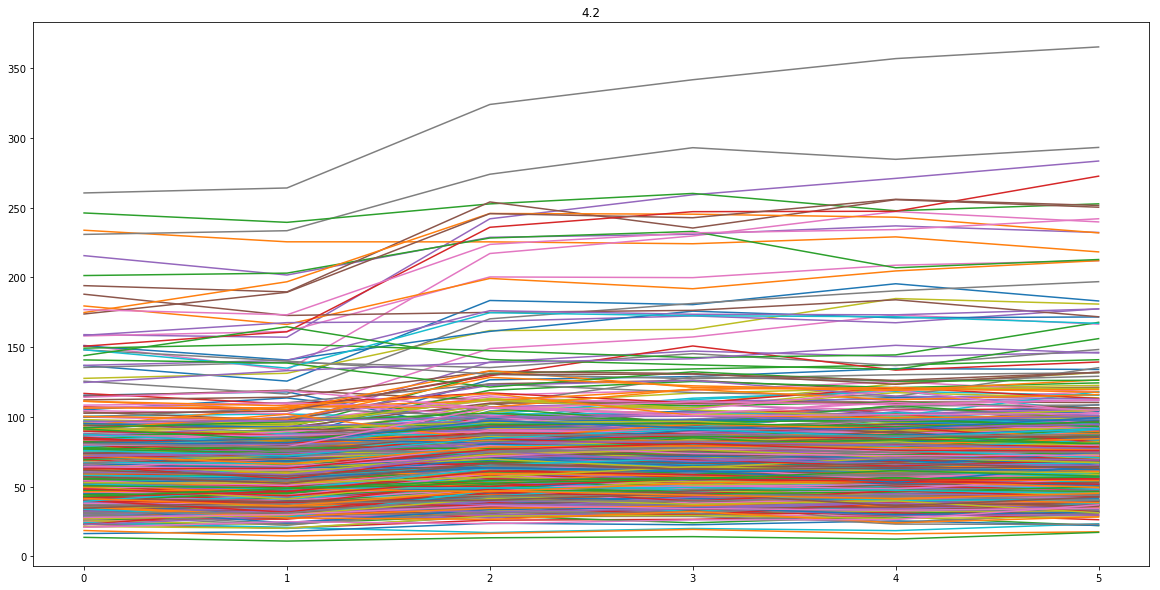

In [33]:
## Analysis of Traces Fluorescence (Y) vs picture number (x) per plate 

plate_number = 1

## If required, analyze evolution between individual time points 

first_picture = 0
last_picture = 8

plt.figure(figsize=(20,10))
#axes = plt.gca()
#axes.set_ylim([3000,3200])
#axes.set_xlim([-150,150])
plt.title("4.2")

## Visualize all traces
#traces = [x[6] for x in compounded_data]

##Visualize one plate
traces = [x[6] for x in compounded_data if x[0] == plate_number]

# Visualize traces from first picture to picture 8
for i in traces:
    plt.plot(i[first_picture:last_picture]);

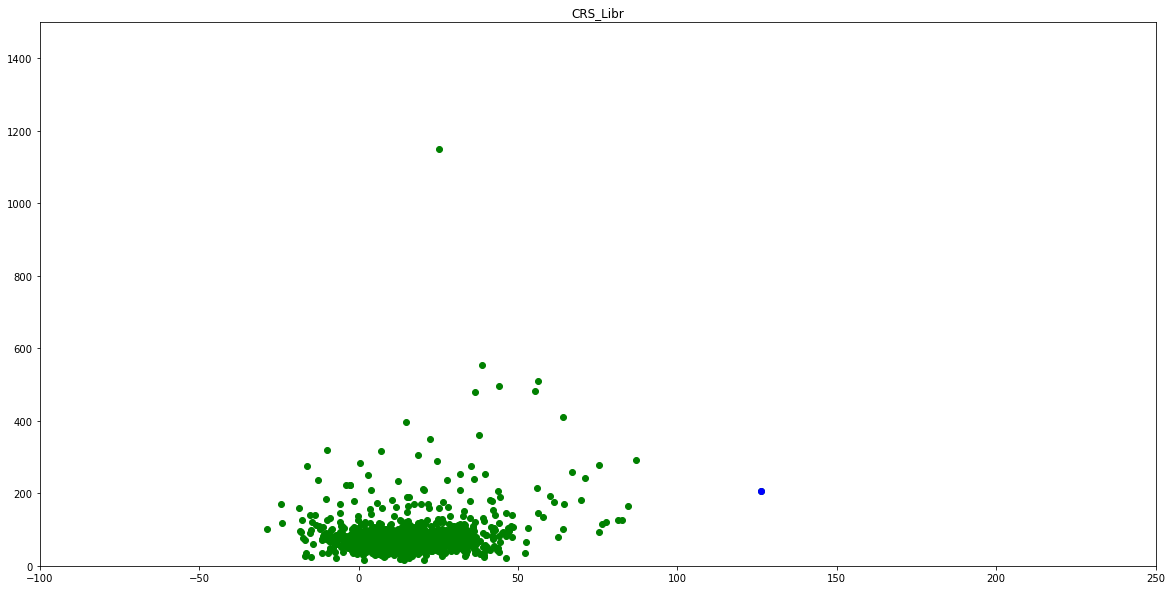

In [41]:
## Defining Picking List

## It sorts all data under the criteria of minimun and/or maximun response x[4] and final fluorescence x[5] 
  
picking_list = sorted([x for x in compounded_data if x[4] > 90 and x[5] > 60 and x[4] < 180 ], key=lambda x: x[4], reverse=True)

plt.figure(figsize=(20,10))
axes = plt.gca()
axes.set_ylim([0,1500])
axes.set_xlim([-100,250])
plt.title("CRS_Libr")

## Allows to visualize selected colonies under the criteria on top of the total population

plt.plot([x[4] for x in compounded_data],[x[5] for x in compounded_data], "go");
plt.plot([x[4] for x in picking_list],[x[5] for x in picking_list], "bo");



In [46]:
len(picking_list)

828

(2, 340, 570.0, 834.0, 126.152874289324)


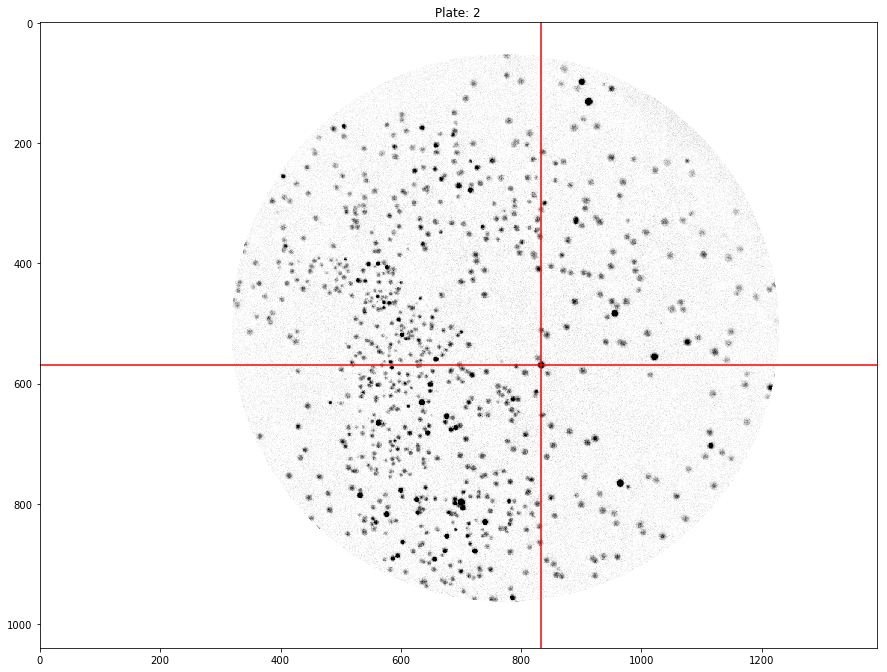

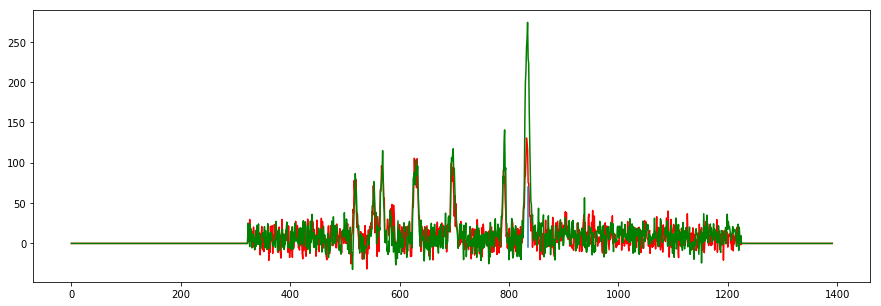

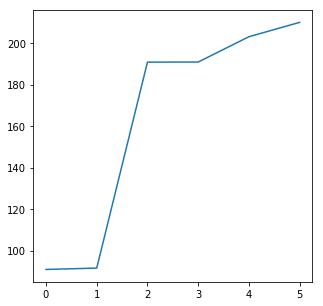

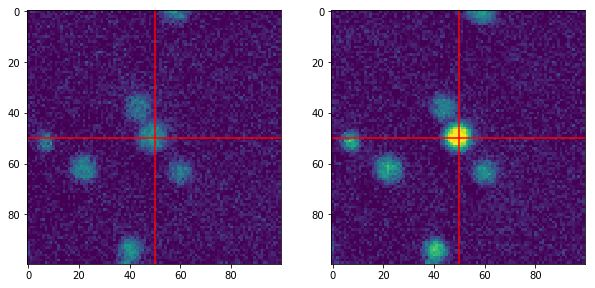

In [39]:
## Analyze sorted clones in the plate and 1D plot. This function works on the defined picking list 

wid.interact(show_colony,number = (0,40),continuous_update=False);

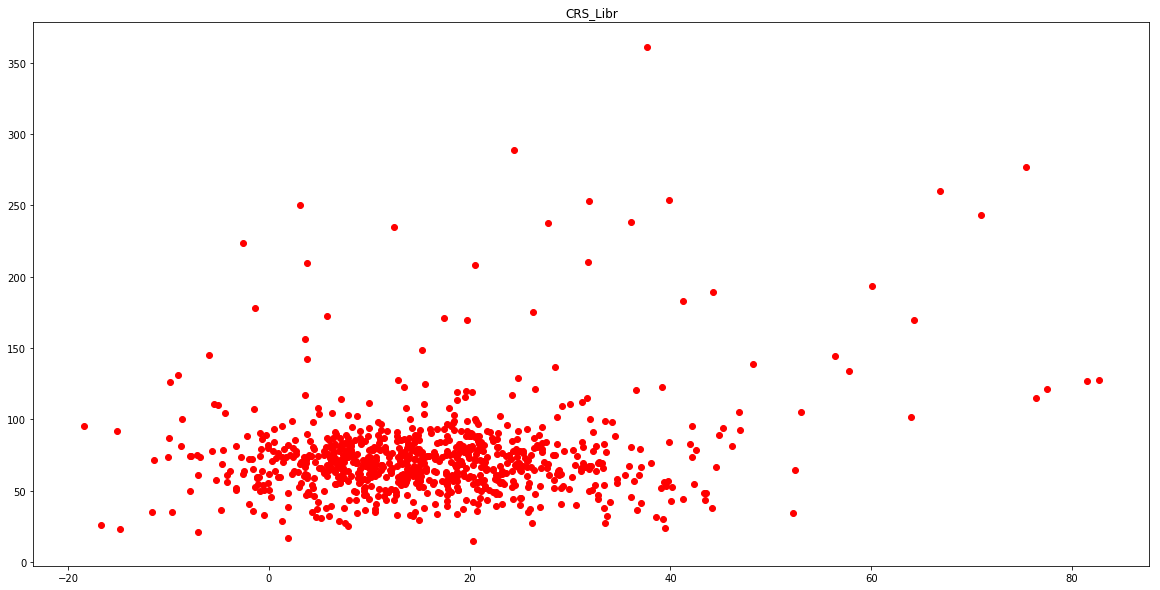

In [25]:
## Analysis of Final Fluorescence (Y) vs Response (x) per plate 

def show_plate_colonies(plate_number):
    plt.figure(figsize=(20,10))
    axes = plt.gca()
    #axes.set_ylim([0,1500])
    #axes.set_xlim([-50,300])
    plt.title("CRS_Libr")

    #plt.plot([x[4] for x in compounded_data ],[x[5] for x in compounded_data], "go");
    plt.plot([x[4] for x in compounded_data if x[0] == plate_number ],[x[5] for x in compounded_data if x[0] == plate_number ], "ro");


wid.interact(show_plate_colonies,plate_number=(1,29));

In [45]:
## Creating a sorted picking List per plate. It is helpful to locate outlayers  

plate_number = 1
picking_list = sorted([x for x in compounded_data if x[0] == plate_number ], key=lambda x: x[4], reverse=True)

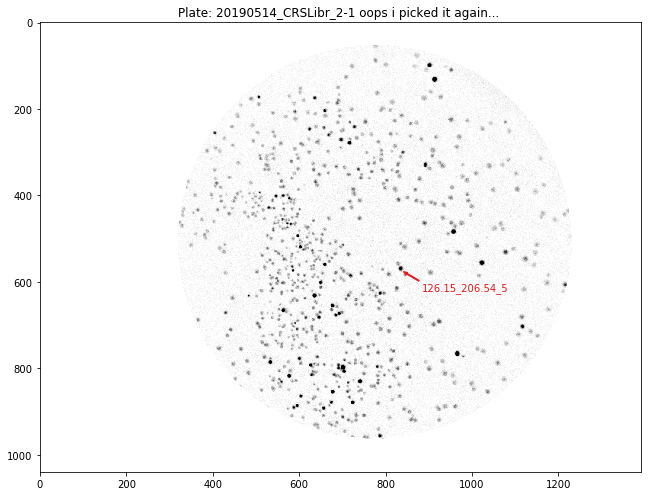

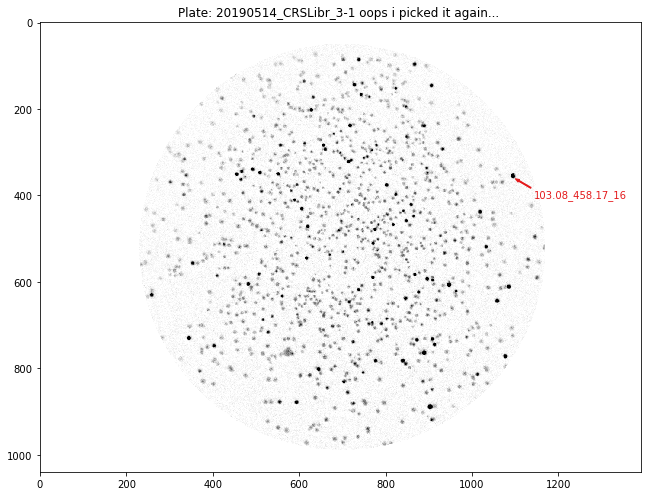

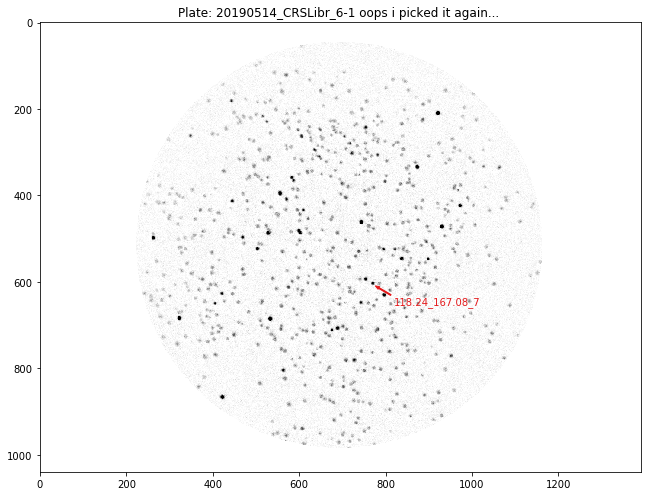

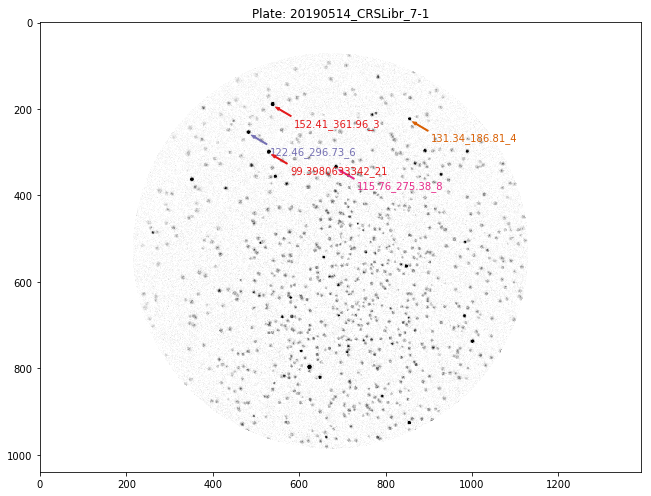

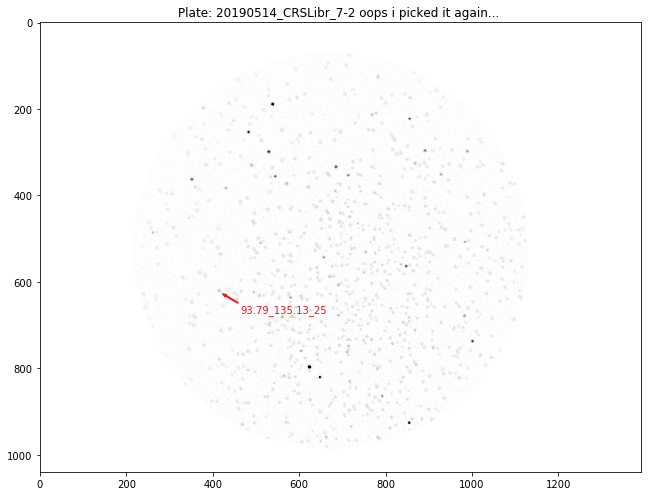

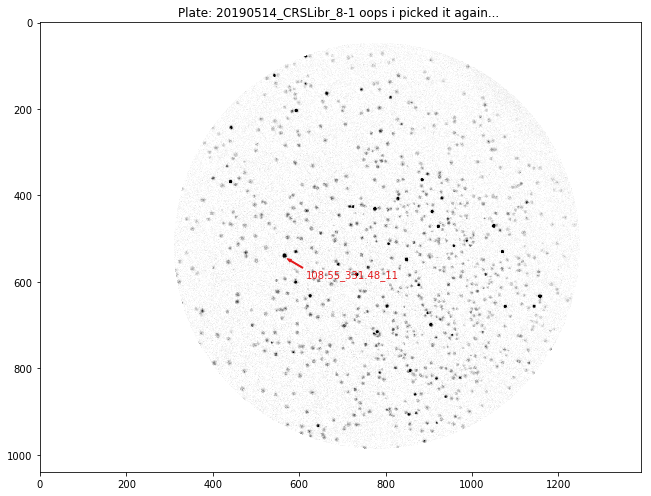

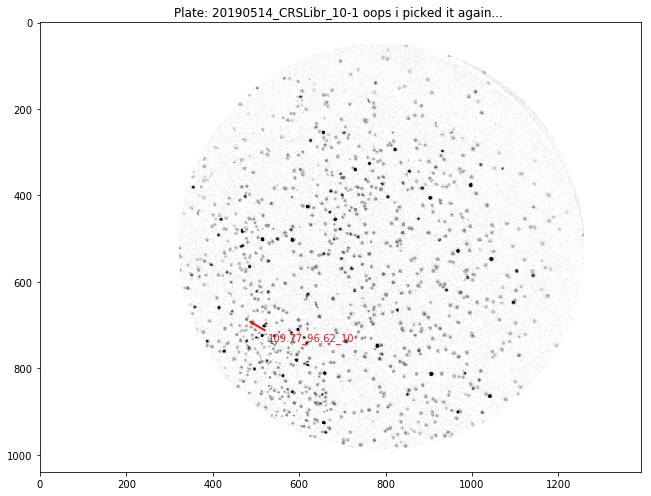

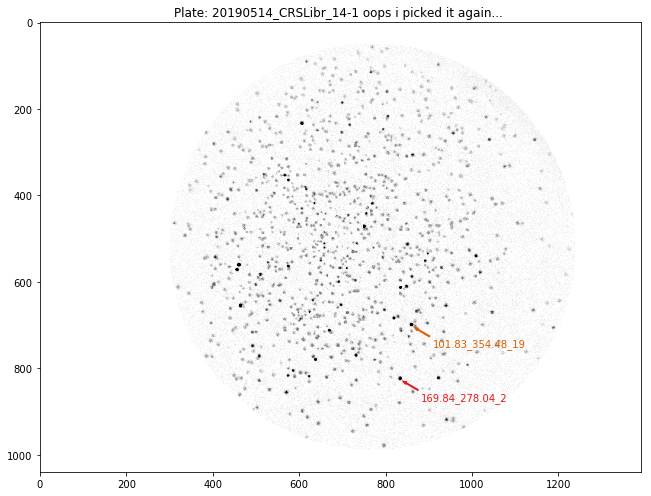

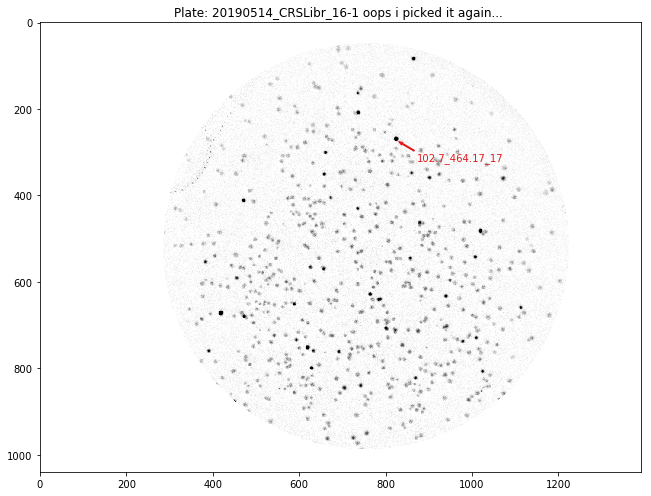

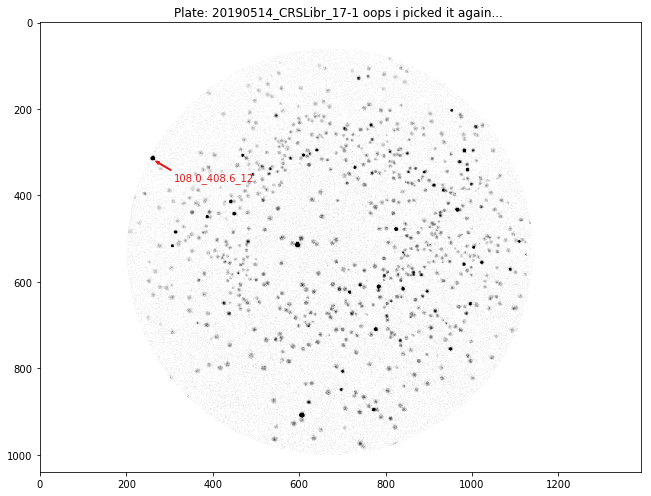

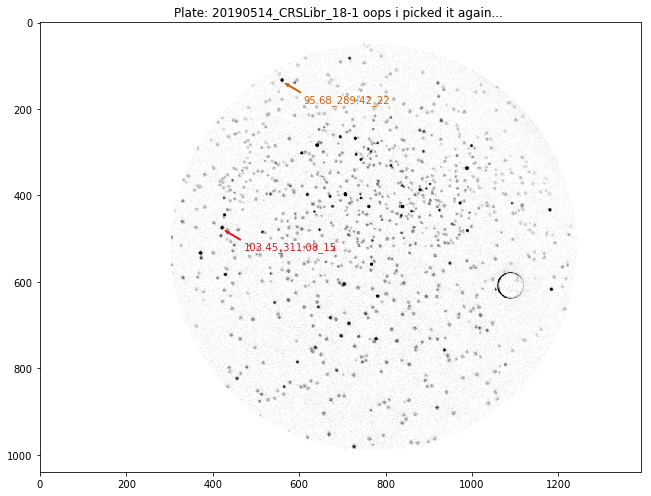

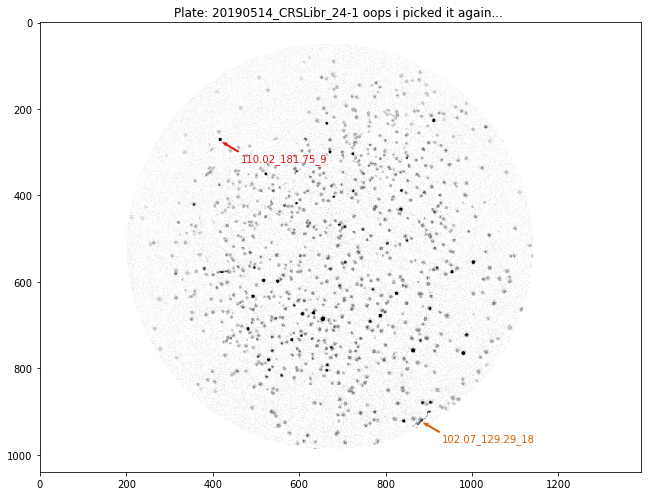

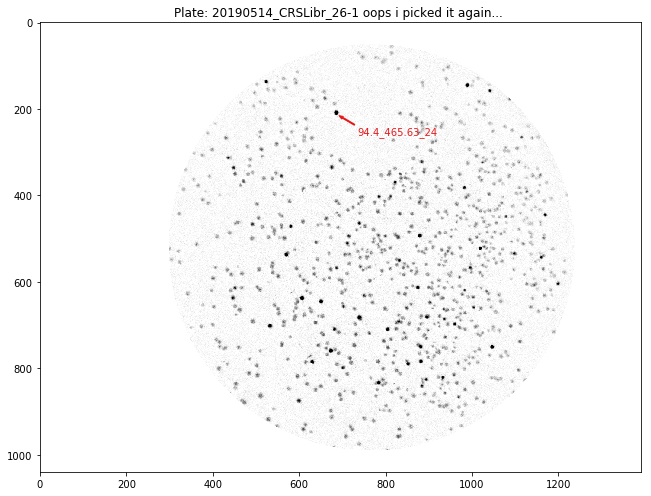

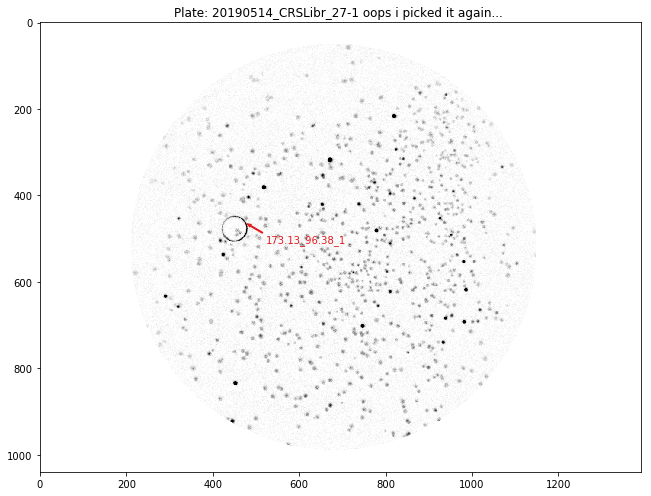

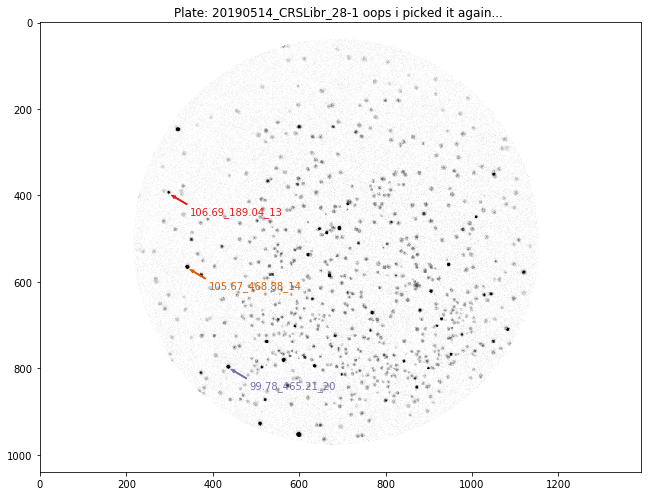

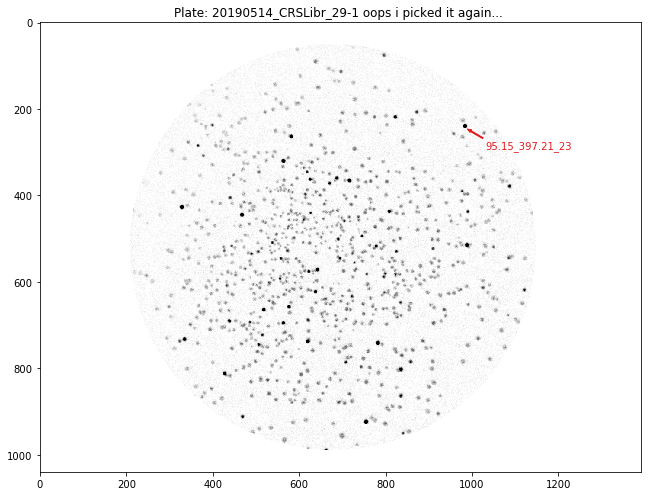

In [141]:
### creating PDF for picking colonies and saving raw data 

### modifieable values 
input_list = picking_list    ### enter list of clonies to pick from
top = 25                        ### change to get top values

folder = "results/"    ### folder name to safe plate pictures for picking 
fileprefix = "20190514_CRSLibr_"    ### file prefix

max_per_plate = 5               ### maximum number of colonies per picture displayed

max_val = 500

###############################################################
picking_list = []               #### empty picking list
count = 0
col_list = ['#e41a1c','#e41a1c','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628']
col_list = ['#e41a1c','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']

### generates list with values for top x colonies in set
for i in input_list[0:top]:
    picking_list.append(i + (count,))
    count += 1

### creates pdf files os all plates mentioned in the top colonies and markes the colonies on plate picture

for i in np.unique([x[0] for x in picking_list]):
    
    plt.figure(figsize=(11.692,8.267))    ### A4 size in inces
    
     
    
    plt.imshow(plate_pics_535_LB[i],cmap="Greys",vmin=0, vmax=200);    ### creates picture of current plate
    
    ### searches the top candidat list for occurances on current plate
    
    counter = 0
    page = 1
    for n in picking_list:
        if i == n[0]:
            
            counter+=1
            
            if counter < max_per_plate:
                          
            
                plt.annotate(str(np.round(n[4],2)) + "_" + str(np.round(n[5],2)) + "_" + str(n[7]+1), xy = (n[3] + 5, n[2] +5),
                            xytext = (n[3] + 50, n[2] + 50),color=col_list[counter-1],
                            arrowprops=dict(color=col_list[counter-1],width = 1, headlength = 4, shrink=0.05, headwidth = 3));
            else:
                plt.annotate(str(n[4])+ "_" + str(n[7]+1), xy = (n[3] + 5, n[2] +5),
                            xytext = (n[3] + 50, n[2] + 50),color=col_list[counter-max_per_plate],
                            arrowprops=dict(color=col_list[counter-max_per_plate],width = 1, headlength = 4, shrink=0.05, headwidth = 3));
                
                
                
                plt.title('Plate: '+ fileprefix + str(i) + "-" + str(page));
                plt.savefig(folder + fileprefix + str(i) + "-" + str(page) + ".pdf", papertype='A4')
                
                counter=0
                page+= 1
                
                
                plt.figure(figsize=(11.692,8.267))    ### A4 size in inces
                plt.imshow(plate_pics_535_LB[i],cmap="Greys",vmin=0, vmax=max_val);    ### creates picture of current plate
            
    if counter > 0:
        plt.title('Plate: '+ fileprefix + str(i) + "-" + str(page) + " oops i picked it again... ");
        plt.savefig(folder + fileprefix + str(i) + "-" + str(page) + ".pdf", papertype='A4')                
        
### saving data of picked colonies


with open(folder + fileprefix + "colony_data_top_" + str(top) + ".txt", "wb") as fp:
    pickle.dump(picking_list, fp)                

outfile = open(folder + fileprefix + "colony_data_top_" + str(top) + ".csv", "w")

outfile.write("plate, plate_type, colony, x, y, 505_raw, 712_raw, ratio, 505, 712, rank \n")

for i in picking_list:
    for n in i:
        outfile.write(str(n) + ",")
    outfile.write("\n")

outfile.close() 